## Постановка задачи
Разработаем оптимальную архитектуру нейронной сети, исходя из исходной задачи классификации.

Разделим данные на обучающие и проверочные в соотношении 80/20.

Используем Keras для построения нейросети с линейным, сверточными слоями и слоями подвыборки.

Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020
![](inception-resnet-v2.jpeg)

### Подключение библиотек

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from skimage import io
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Concatenate, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Используемые функции

In [2]:
filesDir = "train_images_small"
batch_size = 20
image_x = 525
image_y = 350
image_ch = 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        img = image.load_img(os.path.join(filesDir, file),
                     target_size=(image_y, image_x))
        img = image.img_to_array(img)
        x[j] = np.expand_dims(img, axis=0)
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size
            batch_end += batch_size

def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

### Загрузка данных

In [4]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [5]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [6]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
13216                                                NaN  965b308.jpg  Fish
7092   1288267 1121 1289667 1121 1291067 1121 1292467...  5122a3d.jpg  Fish
10220                                                NaN  74808ec.jpg  Fish
14052  57604 446 59004 446 60404 446 61804 446 63204 ...  a0e6825.jpg  Fish
3160                                                 NaN  2385676.jpg  Fish


### Архитектура нейросети
Для выделения характерных особенностей на исходном изображении достаточно ввести несколько сверточных блоков, как предложено в GoogLeNet/Inception: 1x1, 3x3, 2-3x3 и объединить их через MaxPool.

Количество таких блоков будет зависеть от размера области на изображении, которую классифицируем. В случае изображения 525x350 "пятно" облака занимает 2/3 по каждому измерению, до 350x233.

Перед запуском сверточных блоков добавим инициализацию: свертку 3x3 и подвыборку, чтобы уменьшить размерность изображения, это сократит "пятно" в 4 раза, до 58 пикселей. После этого каждый сверточно-выборочный блок уменьшает размер "пятна" в 2 раза => необходимо 3-4 таких блока для успешной классификации (минимальный размер блока после финальной подвыборки - 4, lg(58/4) = 3,8).

Padding-слои нужны для выравнивания размеров входов для объединения на выходе нескольких потоков обработки изображения.

In [40]:
inp = Input(shape=(image_y, image_x, image_ch))
start_3x3 = Conv2D(32, (3,3), padding="valid",
                   strides=(2,2),
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(inp)
start_3x3_act = Activation("relu")(start_3x3)
start_3x3_pool = MaxPooling2D(pool_size=(2,2),
                    padding="same")(start_3x3_act)
input_ = start_3x3_pool
for i in range(3):
    inc_1x1 = Conv2D(32, (1,1), padding="valid",
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(input_)
    inc_1x1_act = Activation("relu")(inc_1x1)
    inc_3x3 = Conv2D(16, (1,1), padding="valid",
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(input_)
    inc_3x3_act = Activation("relu")(inc_3x3)
    inc_3x3_2 = Conv2D(32, (3,3), padding="valid",
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(inc_3x3_act)
    inc_3x3_2_pad = ZeroPadding2D(padding=(1,1))(inc_3x3_2)
    inc_3x3_2_act = Activation("relu")(inc_3x3_2_pad)
    inc_5x5 = Conv2D(16, (1,1), padding="valid",
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(input_)
    inc_5x5_act = Activation("relu")(inc_5x5)
    inc_5x5_2 = Conv2D(32, (5,5), padding="valid",
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(inc_5x5_act)
    inc_5x5_2_pad = ZeroPadding2D(padding=(2,2))(inc_5x5_2)
    inc_5x5_2_act = Activation("relu")(inc_5x5_2_pad)
    inc_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1),
                    padding="same")(input_)
    inc_pool_1x1 = Conv2D(32, (1,1), padding="same",
                   kernel_regularizer=l2(0.0002),
                   kernel_initializer='glorot_uniform')(inc_pool)
    inc_pool_1x1_act = Activation("relu")(inc_pool_1x1)
    inc_conc = Concatenate(axis=1)([inc_1x1_act, inc_3x3_2_act,
                    inc_5x5_2_act, inc_pool_1x1_act])
    inc_output = MaxPooling2D(pool_size=(2,2),
                    padding="same")(inc_conc)
    input_ = inc_output
flat = Flatten()(input_)
flat_bn = BatchNormalization()(flat)
drop = Dropout(0.5)(flat_bn)
drop_act = Activation("softmax")(drop)
final = Dense(1)(drop_act)
model = Model(inputs=inp, outputs=final)

In [46]:
model.compile(optimizer=optimizers.Nadam(lr=0.001),
             loss="mean_absolute_error")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 350, 525, 3)  0                                            
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 174, 262, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 174, 262, 32) 0           conv2d_196[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_75 (MaxPooling2D) (None, 87, 131, 32)  0           activation_204[0][0]             
__________________________________________________________________________________________________
conv2d_198

### Проверка модели
Будем проверять эффективность модели на выборке 100 элементов и 10 эпохах обучения. Эффективная модель будет разделять предсказываемые классы облаков (распределение предсказания будет бимодальным).

Добавим раннюю остановку обучения, если качество предсказания не улучшается в течение 5 эпох (patience).

In [47]:
model.fit_generator(load_data(train, batch_size),
            epochs=100, steps_per_epoch=len(train)//batch_size,
            verbose=True,
            callbacks=[EarlyStopping(monitor="loss",
                min_delta=0.0001, patience=5, verbose=1, mode="auto")])

Epoch 1/100
221/221 [==============================] - 15110s 68s/step - loss: 0.5419
Epoch 2/100
221/221 [==============================] - 1797s 8s/step - loss: 0.5074
Epoch 3/100
221/221 [==============================] - 1707s 8s/step - loss: 0.5038
Epoch 4/100
221/221 [==============================] - 1559s 7s/step - loss: 0.5031
Epoch 5/100
221/221 [==============================] - 1542s 7s/step - loss: 0.4897
Epoch 6/100
221/221 [==============================] - 1577s 7s/step - loss: 0.4815
Epoch 7/100
221/221 [==============================] - 1546s 7s/step - loss: 0.4782
Epoch 8/100
221/221 [==============================] - 1543s 7s/step - loss: 0.4694
Epoch 9/100
221/221 [==============================] - 1543s 7s/step - loss: 0.4667
Epoch 10/100
221/221 [==============================] - 1544s 7s/step - loss: 0.4591
Epoch 11/100
221/221 [==============================] - 1541s 7s/step - loss: 0.4469
Epoch 12/100
221/221 [==============================] - 1580s 7s/step - 

In [48]:
prediction = model.predict_generator(load_data(test, 1),
                        steps=len(test), verbose=1)

1110/1110 [==============================] - 165s 149ms/step


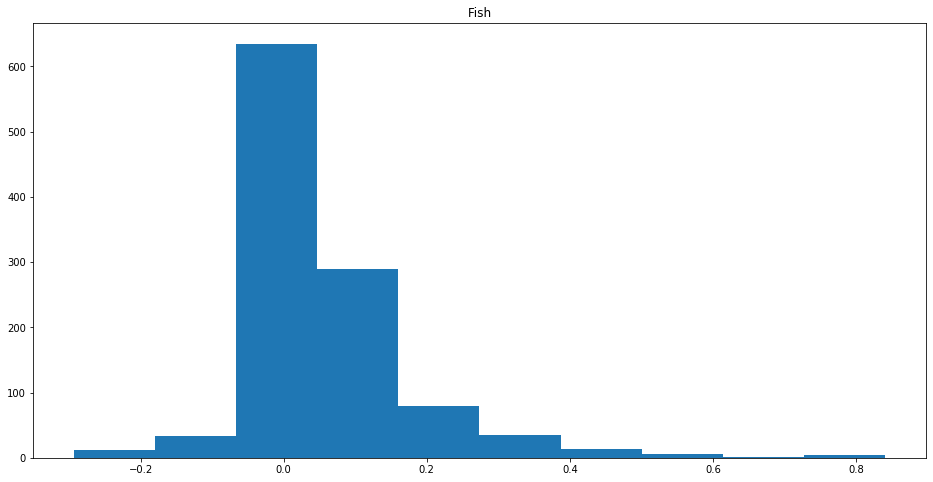

In [49]:
prediction = np.transpose(prediction)
draw_prediction(prediction)

### Предсказание значений

In [56]:
test["target"] = (prediction[0] >= 0.5).astype("i1")

In [57]:
print (test[test["target"]>0]["EncodedPixels"].head(100))

11996                                                  NaN
4716     1043235 786 1044635 786 1046035 786 1047435 78...
13692    304082 904 305482 904 306882 904 308282 904 30...
4808     830320 891 831720 891 833120 891 834520 891 83...
1816                                                   NaN
1964     586621 1173 588021 1173 589421 1173 590821 117...
17236                                                  NaN
16488    681915 838 683315 838 684715 838 686115 838 68...
17668                                                  NaN
11164    705617 8 707017 8 708402 7 708417 8 709802 5 7...
9228     339667 482 341067 482 342467 482 343867 482 34...
Name: EncodedPixels, dtype: object


### Оценка по Дайсу
Пока будем считать, что при определении типа облака на изображении, оно целиком размещено на фотографии: т.е. область облака - это все изображение.

Нет облаков - 0.5, MLP - 0.3, CONV/VGG - 0.48, AlexNet - 0.2, Inception - 0.5, ResNet - 0.55

In [58]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, (CONV3-32x2,POOL2,CONV1/CONV3/CONV5-x3,POOL2):",
      round(dice.mean(), 3))

Keras, (CONV3-32x2,POOL2,CONV1/CONV3/CONV5-x3,POOL2) 0.486
